# Store greenspace metrics at multiple spatial scales

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import rasterio
import os
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import time
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
from rasterio.transform import from_origin
from rasterio.plot import show
from shapely.geometry import box, Point, Polygon
from osgeo import gdal
from geopandas import GeoSeries
from numpy.random import RandomState
from skimage.filters.rank import modal
from skimage.util import img_as_ubyte

%matplotlib inline

In [2]:
#!pip install scikit-learn
#!pip install -U scikit-image

# 1. NDVI

## 1.1. NDVI input map

In [3]:
# data dir
data_dir = r"thesis_project/data"
fp = os.path.join(data_dir, "CR_NDVI.TIF")

# open the file
ndvi_input_raster = rasterio.open(fp)

# check type of the variable 'raster'
type(ndvi_input_raster)

rasterio.io.DatasetReader

In [4]:
# check metadata for the whole raster dataset
ndvi_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.3999999521443642e+38,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

In [5]:
ndvi_input_raster.bounds

BoundingBox(left=341660.6724, bottom=371164.6389, right=416090.6724, top=431034.6389)

In [6]:
# read the raster band as separate variable
ndvi_input = ndvi_input_raster.read(1)
type(ndvi_input)

numpy.ndarray

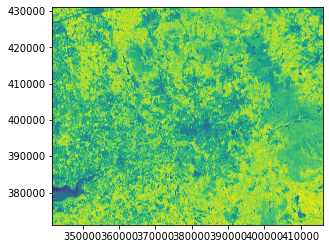

<AxesSubplot:>

In [7]:
# plot input NDVI
show(ndvi_input_raster, 1)

## 1.2. Focal statistics

### 1.2.1. Focal statistics at 100m

In [8]:
# design kernel at a 100m scale
ndvi_filter_100 = np.ones((21, 21))
ndvi_filter_100.shape

(21, 21)

In [9]:
# FFT convolve NDVI input with kernel at 100m (equivalent to average operation)
start_time = time.time()
ndvi_output_100_fft = fftconvolve(ndvi_input, ndvi_filter_100, mode = "same") / np.sum(ndvi_filter_100) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_100_fft.shape

--- 2.7729949951171875 seconds ---


(5987, 7443)

In [10]:
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.910064697265625e-05 seconds ---


### 1.2.2. Focal statistics at 300m

In [11]:
# design kernel at a 300m scale
ndvi_filter_300 = np.ones((61, 61))
ndvi_filter_300.shape

(61, 61)

In [12]:
# FFT convolve NDVI input with kernel at 300m (equivalent to average operation)
start_time = time.time()
ndvi_output_300_fft = fftconvolve(ndvi_input, ndvi_filter_300, mode = "same") / np.sum(ndvi_filter_300) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_300_fft.shape

--- 2.906142234802246 seconds ---


(5987, 7443)

### 1.2.3. Focal statistics at 500m

In [13]:
# design kernel at a 500m scale
ndvi_filter_500 = np.ones((101, 101))
ndvi_filter_500.shape

(101, 101)

In [14]:
# FFT convolve NDVI input with kernel at 500m (equivalent to average operation)
start_time = time.time()
ndvi_output_500_fft = fftconvolve(ndvi_input, ndvi_filter_500, mode = "same") / np.sum(ndvi_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_500_fft.shape

--- 3.0475051403045654 seconds ---


(5987, 7443)

## 1.3. NDVI output layer

### 1.3.1. NDVI output layer at 100m

In [15]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/ndvi_output_100_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_100_fft.shape[0], width = ndvi_output_100_fft.shape[1],
                            count=1, dtype=str(ndvi_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_100_fft, 1)
new_dataset.close()

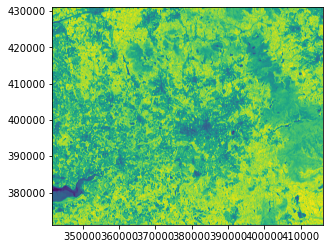

--- 2.4536919593811035 seconds ---


In [16]:
# NDVI layer output at 100m
start_time = time.time()
src_100_fft = rasterio.open("thesis_project/output/ndvi_output_100_fft.tif")
show(src_100_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [17]:
# output layer metadata
src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.2. NDVI output layer at 300m

In [18]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/ndvi_output_300_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_300_fft.shape[0], width = ndvi_output_300_fft.shape[1],
                            count=1, dtype=str(ndvi_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_300_fft, 1)
new_dataset.close()

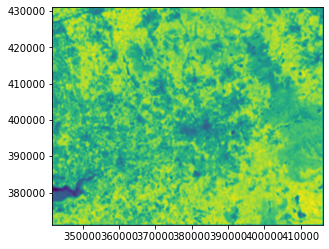

--- 2.3087317943573 seconds ---


In [19]:
# NDVI layer output at 300m
start_time = time.time()
src_300_fft = rasterio.open("thesis_project/output/ndvi_output_300_fft.tif")
show(src_300_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
# check meta
src_300_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.3. NDVI output layer at 500m

In [21]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/ndvi_output_500_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_500_fft.shape[0], width = ndvi_output_500_fft.shape[1],
                            count=1, dtype=str(ndvi_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_500_fft, 1)
new_dataset.close()

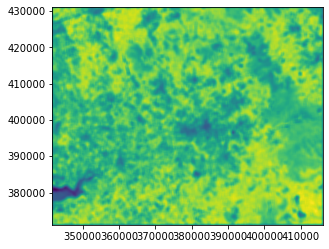

--- 2.289485216140747 seconds ---


In [22]:
# NDVI layer output at 500m
start_time = time.time()
src_500_fft = rasterio.open("thesis_project/output/ndvi_output_500_fft.tif")
show(src_500_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [23]:
# check crs
src_500_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

## 1.4. Generate random points within extent of raster

### 1.4.1. Generate random points at 100m from each other

In [24]:
# extract raster bounds (later input to create the polygon)
bounds = src_100_fft.bounds
bounds

BoundingBox(left=341660.6724, bottom=371164.6389, right=416090.6724, top=431034.6389)

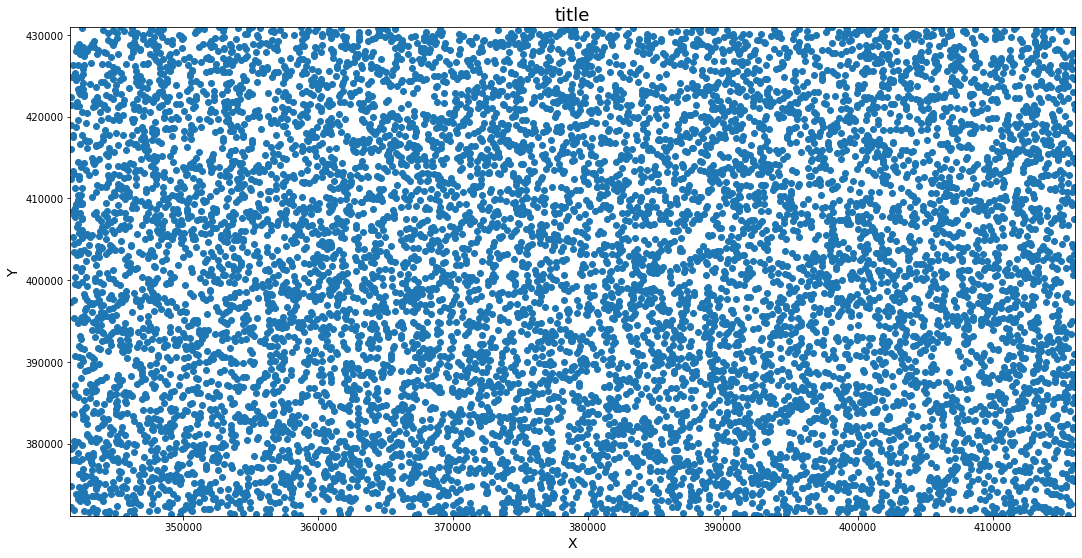

In [25]:
# generate random points at 100m from each other
plt.close("all")

a = 416090.6724         # x bound
b = 431034.6389        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

#prng = RandomState(1234567890)

points_100 = np.array([])       # x, y columnwise
while points_100.shape[0] < 10000:
    np.random.seed(42)
    x = random.choice(np.linspace(341660.6724, a, 100000))
    y = random.choice(np.linspace(371164.6389, b, 100000))
    p = (x,y)
    if len(points_100) == 0:                # add first point blindly
        points_100 = np.array([p])
    elif distance(p, points_100, 100):     # ensure the minimum distance is met
        points_100 = np.vstack((points_100, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([341660.6724, a])
ax.set_ylim([371164.6389, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_100[:,0], points_100[:,1])

In [26]:
# convert np array to point geometry
x, y = np.split(points_100,[-1],axis=1) # split array into x and y
sample_100 = GeoSeries(map(Point, zip(x, y)))
sample_100

0       POINT (345785.624 407650.979)
1       POINT (363233.679 419587.979)
2       POINT (359145.199 405063.372)
3       POINT (342224.857 399372.671)
4       POINT (360059.952 381312.107)
                    ...              
9995    POINT (392916.660 407225.898)
9996    POINT (404711.700 419213.189)
9997    POINT (384779.891 394982.360)
9998    POINT (370364.889 416162.183)
9999    POINT (403792.481 426024.667)
Length: 10000, dtype: geometry

In [27]:
# convert list of point geometries to geodataframe
df_100 = pd.DataFrame(sample_100, columns=['geometry'])
gdf_100 = gpd.GeoDataFrame(df_100, geometry='geometry', crs = 'epsg:27700')
gdf_100.head()                      


,geometry
0,POINT (345785.624 407650.979)
1,POINT (363233.679 419587.979)
2,POINT (359145.199 405063.372)
3,POINT (342224.857 399372.671)
4,POINT (360059.952 381312.107)


In [28]:
# save gpd to GeoJSON
gdf_100.to_file("thesis_project/output/sample_points_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.2. Generate random points at 300m from each other

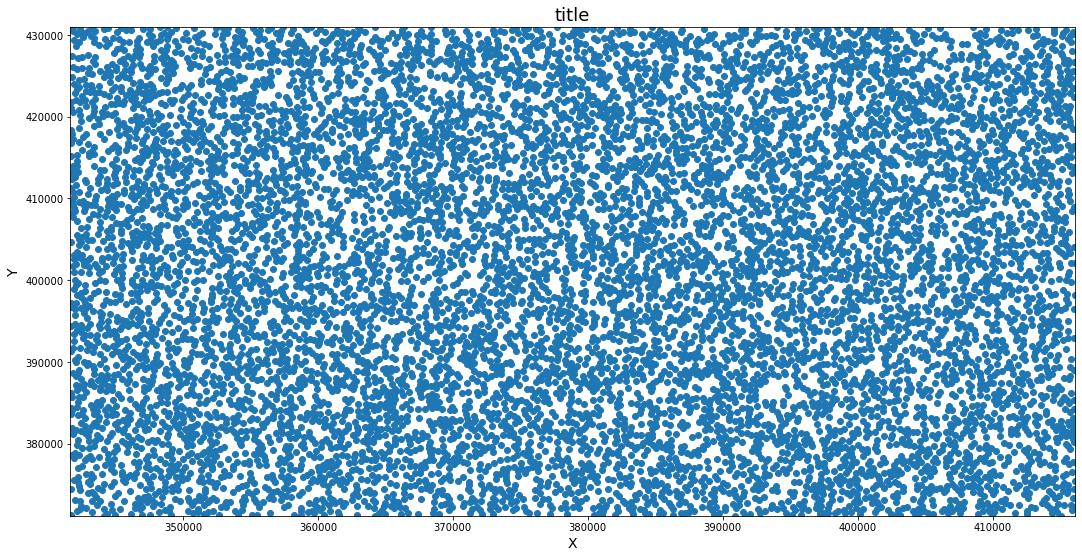

In [29]:
# generate random points at 300m from each other
plt.close("all")

a = 416090.6724         # x bound
b = 431034.6389        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_300 = np.array([])       # x, y columnwise
while points_300.shape[0] < 10000:
    x = random.choice(np.linspace(341660.6724, a, 100000))
    y = random.choice(np.linspace(371164.6389, b, 100000))
    p = (x,y)
    if len(points_300) == 0:                # add first point blindly
        points_300 = np.array([p])
    elif distance(p, points_300, 300):     # ensure the minimum distance is met
        points_300 = np.vstack((points_300, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([341660.6724, a])
ax.set_ylim([371164.6389, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_300[:,0], points_300[:,1])

In [30]:
# convert np array to point geometry
x, y = np.split(points_300,[-1],axis=1) # split array into x and y
sample_300 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_300 = pd.DataFrame(sample_300, columns=['geometry'])
gdf_300 = gpd.GeoDataFrame(df_300, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_300.to_file("thesis_project/output/sample_points_300.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [31]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_300['point_coordinates'] = point_coords
gdf_300.head()

,geometry,point_coordinates
0,POINT (386741.886 372659.009),"(386741.8856121321, 372659.00904370146)"
1,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)"
2,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)"
3,POINT (409088.228 378274.272),"(409088.22797555575, 378274.27249633597)"
4,POINT (344270.959 428665.559),"(344270.958602862, 428665.5593092041)"


### 1.4.3. Generate random points at 500m from each other

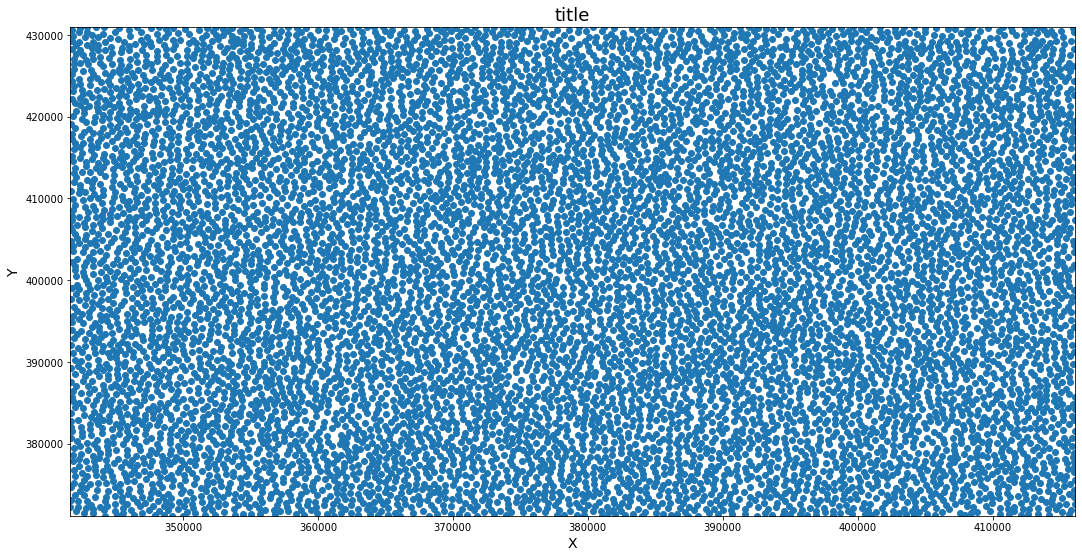

In [32]:
# generate random points at 500m from each other
plt.close("all")

a = 416090.6724         # x bound
b = 431034.6389        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_500 = np.array([])       # x, y columnwise
while points_500.shape[0] < 10000:
    x = random.choice(np.linspace(341660.6724, a, 100000))
    y = random.choice(np.linspace(371164.6389, b, 100000))
    p = (x,y)
    if len(points_500) == 0:                # add first point blindly
        points_500 = np.array([p])
    elif distance(p, points_500, 500):     # ensure the minimum distance is met
        points_500 = np.vstack((points_500, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([341660.6724, a])
ax.set_ylim([371164.6389, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_500[:,0], points_500[:,1])

In [33]:
# convert np array to point geometry
x, y = np.split(points_500,[-1],axis=1) # split array into x and y
points_500 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_500 = pd.DataFrame(points_500, columns=['geometry'])
gdf_500 = gpd.GeoDataFrame(df_500, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_500.to_file("thesis_project/output/sample_points_500.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [34]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_500['point_coordinates'] = point_coords
gdf_500.head()

,geometry,point_coordinates
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)"
1,POINT (346848.495 372350.077),"(346848.4952782288, 372350.07675437856)"
2,POINT (373666.637 426677.257),"(373666.63675964356, 426677.2567261783)"
3,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)"
4,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)"


# 1.5. Extract raster values at point locations and store them into a Geodataframe

### 1.5.1. NDVI values at 100m

In [35]:
# read GeoJSON containing random points
gdf_100 = gpd.read_file("thesis_project/output/sample_points_100.json")
gdf_100.head()
#type(gdf_100)

,geometry
0,POINT (345785.624 407650.979)
1,POINT (363233.679 419587.979)
2,POINT (359145.199 405063.372)
3,POINT (342224.857 399372.671)
4,POINT (360059.952 381312.107)


In [36]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_100['point_coordinates'] = point_coords
gdf_100.head()

,geometry,point_coordinates
0,POINT (345785.624 407650.979),"(345785.6242495185, 407650.97916340263)"
1,POINT (363233.679 419587.979),"(363233.6793300693, 419587.97913340235)"
2,POINT (359145.199 405063.372),"(359145.19854526146, 405063.3718873299)"
3,POINT (342224.857 399372.671),"(342224.8574418504, 399372.6714803258)"
4,POINT (360059.952 381312.107),"(360059.9523927999, 381312.10667467775)"


In [37]:
# open the raster and store metadata
src_100_fft = rasterio.open("thesis_project/output/ndvi_output_100_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_100['NDVI_100'] = [x[0] for x in src_100_fft.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100
0,POINT (345785.624 407650.979),"(345785.6242495185, 407650.97916340263)",0.304726
1,POINT (363233.679 419587.979),"(363233.6793300693, 419587.97913340235)",0.428499
2,POINT (359145.199 405063.372),"(359145.19854526146, 405063.3718873299)",0.663749
3,POINT (342224.857 399372.671),"(342224.8574418504, 399372.6714803258)",0.360014
4,POINT (360059.952 381312.107),"(360059.9523927999, 381312.10667467775)",0.696705


In [38]:
# type of dataframe
type(gdf_100)

geopandas.geodataframe.GeoDataFrame

### 1.5.2. NDVI values at 300m

In [39]:
# read GeoJSON containing random points
gdf_300 = gpd.read_file("thesis_project/output/sample_points_300.json")
gdf_300.head()
#type(gdf_100)

,geometry
0,POINT (386741.886 372659.009)
1,POINT (352668.235 387138.115)
2,POINT (386270.739 413166.857)
3,POINT (409088.228 378274.272)
4,POINT (344270.959 428665.559)


In [40]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_300['point_coordinates'] = point_coords
gdf_300.head()

,geometry,point_coordinates
0,POINT (386741.886 372659.009),"(386741.8856121321, 372659.00904370146)"
1,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)"
2,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)"
3,POINT (409088.228 378274.272),"(409088.22797555575, 378274.27249633597)"
4,POINT (344270.959 428665.559),"(344270.958602862, 428665.5593092041)"


In [41]:
# open the raster and store metadata
src_300_fft = rasterio.open("thesis_project/output/ndvi_output_300_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_300['NDVI_300'] = [x[0] for x in src_300_fft.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300
0,POINT (386741.886 372659.009),"(386741.8856121321, 372659.00904370146)",0.746366
1,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)",0.498663
2,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)",0.539502
3,POINT (409088.228 378274.272),"(409088.22797555575, 378274.27249633597)",0.153383
4,POINT (344270.959 428665.559),"(344270.958602862, 428665.5593092041)",0.691004


### 1.5.3. NDVI values at 500m

In [42]:
# read GeoJSON containing random points
gdf_500 = gpd.read_file("thesis_project/output/sample_points_500.json")
gdf_500.head()
#type(gdf_500)

,geometry
0,POINT (381469.212 392824.025)
1,POINT (346848.495 372350.077)
2,POINT (373666.637 426677.257)
3,POINT (384644.427 417690.081)
4,POINT (372303.810 392721.647)


In [43]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_500['point_coordinates'] = point_coords
gdf_500.head()

,geometry,point_coordinates
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)"
1,POINT (346848.495 372350.077),"(346848.4952782288, 372350.07675437856)"
2,POINT (373666.637 426677.257),"(373666.63675964356, 426677.2567261783)"
3,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)"
4,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)"


In [44]:
# open the raster and store metadata
src_500 = rasterio.open("thesis_project/output/ndvi_output_500_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_500['NDVI_500'] = [x[0] for x in src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)",0.561873
1,POINT (346848.495 372350.077),"(346848.4952782288, 372350.07675437856)",0.630828
2,POINT (373666.637 426677.257),"(373666.63675964356, 426677.2567261783)",0.552437
3,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)",0.396168
4,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)",0.331193


# 2. Greenspace%

## 2.1. Greenspace% input map

In [45]:
# data dir
data_dir = r"thesis_project/data"
fp_green = os.path.join(data_dir, "GreenNoGreenRes.TIF")

# open the file
green_input_raster = rasterio.open(fp_green)

# check type of the variable 'raster'
type(green_input_raster)

rasterio.io.DatasetReader

In [46]:
# check metadata for the whole raster dataset
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

In [47]:
# read the raster band as separate variable
green_input = green_input_raster.read(1)
#type(green_input)
green_input

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

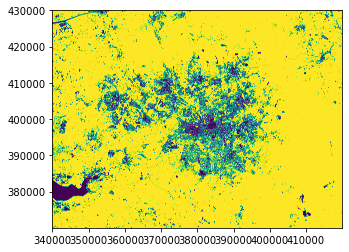

<AxesSubplot:>

In [48]:
# plot input % Greenness
show(green_input_raster, 1)

## 2.2. Focal statistics

### 2.2.1. Focal statistics at 100m

In [49]:
# design kernel at a 100m scale
green_filter_100 = np.ones((41, 41))
green_filter_100.shape

(41, 41)

In [50]:
# FFT convolve Green No Green input with kernel at 100m (r = 41)
start_time = time.time()
green_output_100_fft = fftconvolve(green_input, green_filter_100, mode = "same") / np.sum(green_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_100_fft.shape

--- 25.806723833084106 seconds ---


(12000, 16000)

### 2.2.2. Focal statistics at 300m

In [51]:
# design kernel at a 300m scale
green_filter_300 = np.ones((121, 121))
green_filter_300.shape

(121, 121)

In [52]:
# FFT convolve Green No Green input with kernel at 300m (r = 121)
start_time = time.time()
green_output_300_fft = fftconvolve(green_input, green_filter_300, mode = "same") / np.sum(green_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_300_fft.shape

--- 22.78527593612671 seconds ---


(12000, 16000)

### 2.2.3. Focal statistics at 500m

In [53]:
# design kernel at a 500m scale
green_filter_500 = np.ones((201, 201))
green_filter_500.shape

(201, 201)

In [54]:
# FFT convolve Green No Green input with kernel at 500m (r = 201)
start_time = time.time()
green_output_500_fft = fftconvolve(green_input, green_filter_500, mode = "same") / np.sum(green_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_500_fft.shape

--- 23.138173818588257 seconds ---


(12000, 16000)

## 2.3. Greenspace% output layer

In [55]:
# % greenness input map bounds
green_input_raster.bounds

BoundingBox(left=339999.2458, bottom=370003.9122, right=419999.2458, top=430003.9122)

In [56]:
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.1. Greenspace% output layer at 100m

In [57]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/greenspace_output_100_fft.tif', 'w', driver='GTiff',
                            height = green_output_100_fft.shape[0], width = green_output_100_fft.shape[1],
                            count=1, dtype=str(green_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_100_fft, 1)
new_dataset.close()

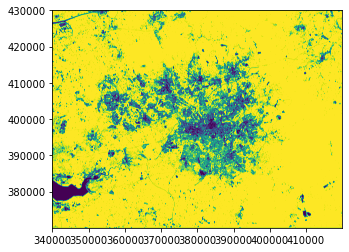

--- 15.382981777191162 seconds ---


In [58]:
# % greenness layer output at 100m
start_time = time.time()
src_100_fft = rasterio.open("thesis_project/output/greenspace_output_100_fft.tif")
show(src_100_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [59]:
# output layer metadata
src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.2. Greenspace% output layer at 300m

In [60]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/greenspace_output_300_fft.tif', 'w', driver='GTiff',
                            height = green_output_300_fft.shape[0], width = green_output_300_fft.shape[1],
                            count=1, dtype=str(green_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_300_fft, 1)
new_dataset.close()

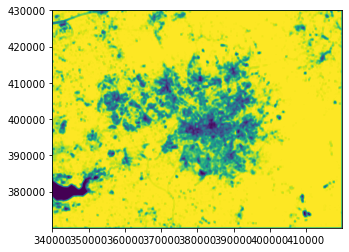

--- 22.617302894592285 seconds ---


In [61]:
# % greenness layer output at 300m
start_time = time.time()
src_300_fft = rasterio.open("thesis_project/output/greenspace_output_300_fft.tif")
show(src_300_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [62]:
# output layer metadata
src_300_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.3. Greenspace% output layer at 500m

In [63]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/greenspace_output_500_fft.tif', 'w', driver='GTiff',
                            height = green_output_500_fft.shape[0], width = green_output_500_fft.shape[1],
                            count=1, dtype=str(green_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_500_fft, 1)
new_dataset.close()

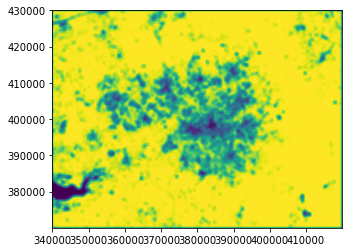

--- 15.988267660140991 seconds ---


In [64]:
# % greenness layer output at 500m
start_time = time.time()
src_500_fft = rasterio.open("thesis_project/output/greenspace_output_500_fft.tif")
show(src_500_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [65]:
# output layer metadata
src_500_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

## 2.4. Extract raster values at point locations and store them into a Geodataframe

### 2.4.1. Greenspace% values at 100m

In [66]:
# open the raster and store metadata
green_src_100 = rasterio.open("thesis_project/output/greenspace_output_100_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_100['Greenspace%_100'] = [x[0] for x in green_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (345785.624 407650.979),"(345785.6242495185, 407650.97916340263)",0.304726,0.947650
1,POINT (363233.679 419587.979),"(363233.6793300693, 419587.97913340235)",0.428499,1.000000
2,POINT (359145.199 405063.372),"(359145.19854526146, 405063.3718873299)",0.663749,0.994051
3,POINT (342224.857 399372.671),"(342224.8574418504, 399372.6714803258)",0.360014,0.886972
4,POINT (360059.952 381312.107),"(360059.9523927999, 381312.10667467775)",0.696705,1.000000


In [67]:
# check if null values in gdf
gdf_100.isnull().values.any()

False

### 2.4.2. Greenspace% values at 300m

In [68]:
# open the raster and store metadata
green_src_300 = rasterio.open("thesis_project/output/greenspace_output_300_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_300['Greenspace%_300'] = [x[0] for x in green_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (386741.886 372659.009),"(386741.8856121321, 372659.00904370146)",0.746366,1.000000
1,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)",0.498663,0.954375
2,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)",0.539502,0.777338
3,POINT (409088.228 378274.272),"(409088.22797555575, 378274.27249633597)",0.153383,0.362748
4,POINT (344270.959 428665.559),"(344270.958602862, 428665.5593092041)",0.691004,0.993989


In [69]:
# check if null values in gdf
gdf_300.isnull().values.any()

False

### 2.4.3. Greenspace% values at 500m

In [70]:
# open the raster and store metadata
green_src_500 = rasterio.open("thesis_project/output/greenspace_output_500_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_500['Greenspace%_500'] = [x[0] for x in green_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)",0.561873,0.843865
1,POINT (346848.495 372350.077),"(346848.4952782288, 372350.07675437856)",0.630828,0.992079
2,POINT (373666.637 426677.257),"(373666.63675964356, 426677.2567261783)",0.552437,0.962476
3,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)",0.396168,0.969951
4,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)",0.331193,0.472315


In [71]:
# check if null values in gdf
gdf_500.isnull().values.any()

False

# 3. Canopy%

## 3.1. Canopy% input map

In [72]:
# data dir
data_dir = r"thesis_project/data"
fp_tree = os.path.join(data_dir, "Tree_no_trees_2m.TIF")

# open the file
tree_input_raster = rasterio.open(fp_tree)

# check type of the variable 'raster'
type(tree_input_raster)

rasterio.io.DatasetReader

In [73]:
# check metadata for the whole raster dataset
tree_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 26119,
 'height': 19520,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(2.0, 0.0, 351667.1259,
        0.0, -2.0, 420207.084)}

In [74]:
# read the raster band as separate variable
tree_input = tree_input_raster.read(1)
#tree_input
type(tree_input)


numpy.ndarray

In [75]:
# convert array to uint8
tree_input = tree_input.astype(np.uint8)
tree_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

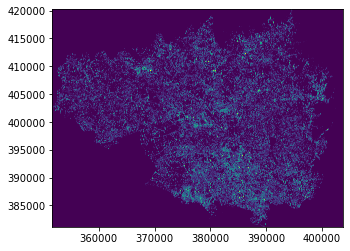

<AxesSubplot:>

In [76]:
# plot Tree No Trees input map
show(tree_input_raster, 1)

## 3.2. Focal statistics

### 3.2.1. Focal statistics at 100m

In [77]:
# design kernel at a 100m scale
tree_filter_100 = np.ones((101, 101))
tree_filter_100.shape

(101, 101)

In [78]:
# FFT convolve Tree No Trees input with kernel at 100m (r = 101)
start_time = time.time()
tree_output_100_fft = fftconvolve(tree_input, tree_filter_100, mode = "same") / np.sum(tree_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_100_fft.shape

--- 190.91330289840698 seconds ---


(19520, 26119)

### 3.2.2. Focal statistics at 300m

In [79]:
# design kernel at a 300m scale
tree_filter_300 = np.ones((301, 301))
tree_filter_300.shape

(301, 301)

In [80]:
# FFT convolve Tree No Trees input with kernel at 300m (r = 301)
start_time = time.time()
tree_output_300_fft = fftconvolve(tree_input, tree_filter_300, mode = "same") / np.sum(tree_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_300_fft.shape

--- 272.0461618900299 seconds ---


(19520, 26119)

### 3.2.3. Focal statistics at 500m

In [81]:
# design kernel at a 500m scale
tree_filter_500 = np.ones((501, 501))
tree_filter_500.shape

(501, 501)

In [82]:
# FFT convolve Tree No Trees input with kernel at 500m (r = 501)
start_time = time.time()
tree_output_500_fft = fftconvolve(tree_input, tree_filter_500, mode = "same") / np.sum(tree_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_500_fft.shape

--- 354.76993107795715 seconds ---


(19520, 26119)

## 3.3. Canopy% output layer

In [83]:
# checking bounds
tree_input_raster.bounds

BoundingBox(left=351667.1259, bottom=381167.084, right=403905.1259, top=420207.084)

### 3.3.1. Canopy% output layer at 100m

In [84]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/canopy_output_100_fft.tif', 'w', driver='GTiff',
                            height = tree_output_100_fft.shape[0], width = tree_output_100_fft.shape[1],
                            count=1, dtype=str(tree_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_100_fft, 1)
new_dataset.close()

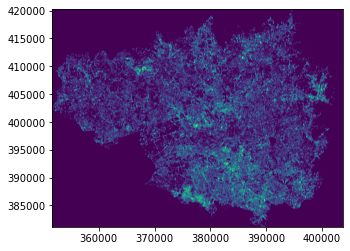

--- 40.87235617637634 seconds ---


In [85]:
# Tree no Trees output layer at 100m
start_time = time.time()
tree_src_100_fft = rasterio.open("thesis_project/output/canopy_output_100_fft.tif")
show(tree_src_100_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [86]:
# output layer metadata
tree_src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 26119,
 'height': 19520,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(2.0, 0.0, 351667.1259,
        0.0, -2.0, 420207.084)}

### 3.3.2. Canopy% output layer at 300m

In [87]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/canopy_output_300_fft.tif', 'w', driver='GTiff',
                            height = tree_output_300_fft.shape[0], width = tree_output_300_fft.shape[1],
                            count=1, dtype=str(tree_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_300_fft, 1)
new_dataset.close()

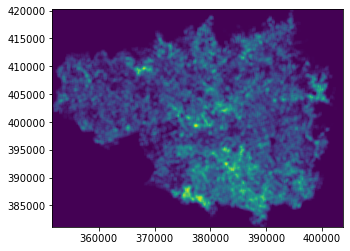

--- 57.827616930007935 seconds ---


In [88]:
# Tree no Trees output layer at 300m
start_time = time.time()
tree_src_300_fft = rasterio.open("thesis_project/output/canopy_output_300_fft.tif")
show(tree_src_300_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

### 3.3.3. Canopy% output layer at 500m

In [89]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/canopy_output_500_fft.tif', 'w', driver='GTiff',
                            height = tree_output_500_fft.shape[0], width = tree_output_500_fft.shape[1],
                            count=1, dtype=str(tree_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_500_fft, 1)
new_dataset.close()

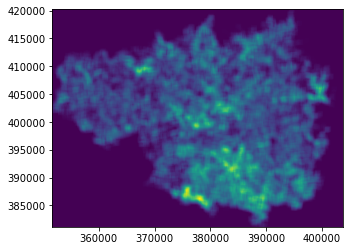

--- 49.48949599266052 seconds ---


In [90]:
# Tree no Trees output layer at 500m
start_time = time.time()
tree_src_500_fft = rasterio.open("thesis_project/output/canopy_output_500_fft.tif")
show(tree_src_500_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

## 3.4. Extract raster values at point locations and store them into a Geodataframe

### 3.4.1. Canopy% values at 100m

In [91]:
# open the raster and store metadata
tree_src_100 = rasterio.open("thesis_project/output/canopy_output_100_fft.tif")
tree_src_100.bounds

BoundingBox(left=351667.1259, bottom=381167.084, right=403905.1259, top=420207.084)

In [92]:
# check gdf
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (345785.624 407650.979),"(345785.6242495185, 407650.97916340263)",0.304726,0.947650
1,POINT (363233.679 419587.979),"(363233.6793300693, 419587.97913340235)",0.428499,1.000000
2,POINT (359145.199 405063.372),"(359145.19854526146, 405063.3718873299)",0.663749,0.994051
3,POINT (342224.857 399372.671),"(342224.8574418504, 399372.6714803258)",0.360014,0.886972
4,POINT (360059.952 381312.107),"(360059.9523927999, 381312.10667467775)",0.696705,1.000000


In [93]:
# create polygon with tree raster bounds
polygon = Polygon([(351667.1259, 381167.084), (351667.1259, 420207.084), (403905.1259, 420207.084), (403905.1259, 381167.084)])


In [94]:
# keep list of points within tree raster bounds
tree_100_points = []
for p in gdf_100.geometry:
    if polygon.contains(p):
        tree_100_points.append(p)
        
len(tree_100_points) #4954 points within tree raster extent
#tree_100_points

4576

In [95]:
tree_df_100 = pd.DataFrame(tree_100_points, columns=['geometry'])
tree_gdf_100 = gpd.GeoDataFrame(tree_df_100, geometry='geometry', crs = 'epsg:27700')                   
tree_gdf_100.head()


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (363233.679 419587.979)
1,POINT (359145.199 405063.372)
2,POINT (360059.952 381312.107)
3,POINT (402000.933 384440.345)
4,POINT (372192.908 390005.318)


In [96]:
# obtain point coordinates (x, y) from point geometry (x y) to later sample raster values
point_coords = []
for index, row in tree_gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
tree_gdf_100['point_coordinates'] = point_coords
tree_gdf_100.head()

,geometry,point_coordinates
0,POINT (363233.679 419587.979),"(363233.6793300693, 419587.97913340235)"
1,POINT (359145.199 405063.372),"(359145.19854526146, 405063.3718873299)"
2,POINT (360059.952 381312.107),"(360059.9523927999, 381312.10667467775)"
3,POINT (402000.933 384440.345),"(402000.932502601, 384440.3454570656)"
4,POINT (372192.908 390005.318),"(372192.9080223562, 390005.3176067871)"


In [97]:
# sample the raster at every point location and store values in Geodataframe
tree_gdf_100['Canopy%_100'] = [x[0] for x in tree_src_100.sample(tree_gdf_100.point_coordinates)]
tree_gdf_100.head()

,geometry,point_coordinates,Canopy%_100
0,POINT (363233.679 419587.979),"(363233.6793300693, 419587.97913340235)",2.994055e-17
1,POINT (359145.199 405063.372),"(359145.19854526146, 405063.3718873299)",6.960102e-03
2,POINT (360059.952 381312.107),"(360059.9523927999, 381312.10667467775)",8.094075e-18
3,POINT (402000.933 384440.345),"(402000.932502601, 384440.3454570656)",2.343414e-17
4,POINT (372192.908 390005.318),"(372192.9080223562, 390005.3176067871)",6.949719e-17


In [98]:
# drop point_coordinates
tree_gdf_100 = tree_gdf_100[['geometry', 'Canopy%_100']]
tree_gdf_100.head()

,geometry,Canopy%_100
0,POINT (363233.679 419587.979),2.994055e-17
1,POINT (359145.199 405063.372),6.960102e-03
2,POINT (360059.952 381312.107),8.094075e-18
3,POINT (402000.933 384440.345),2.343414e-17
4,POINT (372192.908 390005.318),6.949719e-17


In [99]:
# check gdf with other greenspace metrics
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (345785.624 407650.979),"(345785.6242495185, 407650.97916340263)",0.304726,0.947650
1,POINT (363233.679 419587.979),"(363233.6793300693, 419587.97913340235)",0.428499,1.000000
2,POINT (359145.199 405063.372),"(359145.19854526146, 405063.3718873299)",0.663749,0.994051
3,POINT (342224.857 399372.671),"(342224.8574418504, 399372.6714803258)",0.360014,0.886972
4,POINT (360059.952 381312.107),"(360059.9523927999, 381312.10667467775)",0.696705,1.000000


In [100]:
# merge gdf with tree gdf on geometry using left operation
gdf_100_complete = pd.merge(gdf_100, tree_gdf_100, on='geometry', how='left')
gdf_100_complete.head()


,geometry,point_coordinates,NDVI_100,Greenspace%_100,Canopy%_100
0,POINT (345785.624 407650.979),"(345785.6242495185, 407650.97916340263)",0.304726,0.947650,NaN
1,POINT (363233.679 419587.979),"(363233.6793300693, 419587.97913340235)",0.428499,1.000000,2.994055e-17
2,POINT (359145.199 405063.372),"(359145.19854526146, 405063.3718873299)",0.663749,0.994051,6.960102e-03
3,POINT (342224.857 399372.671),"(342224.8574418504, 399372.6714803258)",0.360014,0.886972,NaN
4,POINT (360059.952 381312.107),"(360059.9523927999, 381312.10667467775)",0.696705,1.000000,8.094075e-18


In [101]:
# check if nulls
gdf_100_complete.isnull().values.any()

True

In [102]:
# take rows where 'Canopy%_100' is not NaN
gdf_100 = gdf_100_complete[gdf_100_complete['Canopy%_100'].notna()]
len(gdf_100)

4576

In [103]:
# drop tuple point_coordinates
gdf_100 = gdf_100[['geometry', 'NDVI_100', 'Greenspace%_100', 'Canopy%_100']]
gdf_100.head()

,geometry,NDVI_100,Greenspace%_100,Canopy%_100
1,POINT (363233.679 419587.979),0.428499,1.000000,2.994055e-17
2,POINT (359145.199 405063.372),0.663749,0.994051,6.960102e-03
4,POINT (360059.952 381312.107),0.696705,1.000000,8.094075e-18
5,POINT (402000.933 384440.345),0.635641,1.000000,2.343414e-17
11,POINT (372192.908 390005.318),0.482976,0.988102,6.949719e-17


In [104]:
# save geodataframe to geojson
gdf_100.to_file("thesis_project/output/greenspace_metrics_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 3.4.2. Canopy% values at 300m

In [105]:
# check gdf
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (386741.886 372659.009),"(386741.8856121321, 372659.00904370146)",0.746366,1.000000
1,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)",0.498663,0.954375
2,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)",0.539502,0.777338
3,POINT (409088.228 378274.272),"(409088.22797555575, 378274.27249633597)",0.153383,0.362748
4,POINT (344270.959 428665.559),"(344270.958602862, 428665.5593092041)",0.691004,0.993989


In [106]:
# keep list of points within tree raster bounds
tree_300_points = []
for p in gdf_300.geometry:
    if polygon.contains(p):
        tree_300_points.append(p)
        
len(tree_300_points)
#tree_300_points

4591

In [107]:
tree_df_300 = pd.DataFrame(tree_300_points, columns=['geometry'])
tree_gdf_300 = gpd.GeoDataFrame(tree_df_300, geometry='geometry', crs = 'epsg:27700')                   
tree_gdf_300.head()

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (352668.235 387138.115)
1,POINT (386270.739 413166.857)
2,POINT (394222.920 407216.319)
3,POINT (382436.067 405510.605)
4,POINT (393981.020 411248.603)


In [108]:
# obtain point coordinates (x, y) from point geometry (x y) to later sample raster values
point_coords = []
for index, row in tree_gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
tree_gdf_300['point_coordinates'] = point_coords
tree_gdf_300.head()

,geometry,point_coordinates
0,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)"
1,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)"
2,POINT (394222.920 407216.319),"(394222.9197224732, 407216.3186167972)"
3,POINT (382436.067 405510.605),"(382436.06705394655, 405510.6052596636)"
4,POINT (393981.020 411248.603),"(393981.019803474, 411248.60343964543)"


In [109]:
# open the raster and store metadata
tree_src_300 = rasterio.open("thesis_project/output/canopy_output_300_fft.tif")

# sample the raster at every point location and store values in Geodataframe
tree_gdf_300['Canopy%_300'] = [x[0] for x in tree_src_300.sample(tree_gdf_300.point_coordinates)]
tree_gdf_300.head()

,geometry,point_coordinates,Canopy%_300
0,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)",-3.742610e-17
1,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)",1.298551e-01
2,POINT (394222.920 407216.319),"(394222.9197224732, 407216.3186167972)",2.544122e-02
3,POINT (382436.067 405510.605),"(382436.06705394655, 405510.6052596636)",8.506529e-02
4,POINT (393981.020 411248.603),"(393981.019803474, 411248.60343964543)",8.034128e-02


In [110]:
# drop point_coordinates
tree_gdf_300 = tree_gdf_300[['geometry', 'Canopy%_300']]
tree_gdf_300.head()

,geometry,Canopy%_300
0,POINT (352668.235 387138.115),-3.742610e-17
1,POINT (386270.739 413166.857),1.298551e-01
2,POINT (394222.920 407216.319),2.544122e-02
3,POINT (382436.067 405510.605),8.506529e-02
4,POINT (393981.020 411248.603),8.034128e-02


In [111]:
# check gdf with other greenspace metrics
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (386741.886 372659.009),"(386741.8856121321, 372659.00904370146)",0.746366,1.000000
1,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)",0.498663,0.954375
2,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)",0.539502,0.777338
3,POINT (409088.228 378274.272),"(409088.22797555575, 378274.27249633597)",0.153383,0.362748
4,POINT (344270.959 428665.559),"(344270.958602862, 428665.5593092041)",0.691004,0.993989


In [112]:
# merge gdf with tree gdf on geometry using left operation
gdf_300_complete = pd.merge(gdf_300, tree_gdf_300, on='geometry', how='left')
gdf_300_complete.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,Canopy%_300
0,POINT (386741.886 372659.009),"(386741.8856121321, 372659.00904370146)",0.746366,1.000000,NaN
1,POINT (352668.235 387138.115),"(352668.23517562775, 387138.1146347574)",0.498663,0.954375,-3.742610e-17
2,POINT (386270.739 413166.857),"(386270.739000666, 413166.85742218525)",0.539502,0.777338,1.298551e-01
3,POINT (409088.228 378274.272),"(409088.22797555575, 378274.27249633597)",0.153383,0.362748,NaN
4,POINT (344270.959 428665.559),"(344270.958602862, 428665.5593092041)",0.691004,0.993989,NaN


In [113]:
# check if nulls
gdf_300_complete.isnull().values.any()

True

In [114]:
# take rows where 'Canopy%_300' is not NaN
gdf_300 = gdf_300_complete[gdf_300_complete['Canopy%_300'].notna()]
len(gdf_300) == len(tree_300_points)

True

In [115]:
# drop tuple point_coordinates
gdf_300 = gdf_300[['geometry', 'NDVI_300', 'Greenspace%_300', 'Canopy%_300']]
gdf_300.head()

,geometry,NDVI_300,Greenspace%_300,Canopy%_300
1,POINT (352668.235 387138.115),0.498663,0.954375,-3.742610e-17
2,POINT (386270.739 413166.857),0.539502,0.777338,1.298551e-01
6,POINT (394222.920 407216.319),0.554259,0.857387,2.544122e-02
7,POINT (382436.067 405510.605),0.501188,0.704050,8.506529e-02
9,POINT (393981.020 411248.603),0.557274,0.760945,8.034128e-02


In [116]:
# save geodataframe to geojson
gdf_300.to_file("thesis_project/output/greenspace_metrics_300.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 3.4.3. Canopy% values at 500m

In [117]:
# check gdf
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)",0.561873,0.843865
1,POINT (346848.495 372350.077),"(346848.4952782288, 372350.07675437856)",0.630828,0.992079
2,POINT (373666.637 426677.257),"(373666.63675964356, 426677.2567261783)",0.552437,0.962476
3,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)",0.396168,0.969951
4,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)",0.331193,0.472315


In [118]:
# keep list of points within tree raster bounds
tree_500_points = []
for p in gdf_500.geometry:
    if polygon.contains(p):
        tree_500_points.append(p)
        
len(tree_500_points)
#tree_500_points

4541

In [119]:
tree_df_500 = pd.DataFrame(tree_500_points, columns=['geometry'])
tree_gdf_500 = gpd.GeoDataFrame(tree_df_500, geometry='geometry', crs = 'epsg:27700')                   
tree_gdf_500.head()

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (381469.212 392824.025)
1,POINT (384644.427 417690.081)
2,POINT (372303.810 392721.647)
3,POINT (368906.046 412662.747)
4,POINT (376491.284 394547.700)


In [120]:
# obtain point coordinates (x, y) from point geometry (x y) to later sample raster values
point_coords = []
for index, row in tree_gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
tree_gdf_500['point_coordinates'] = point_coords
tree_gdf_500.head()

,geometry,point_coordinates
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)"
1,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)"
2,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)"
3,POINT (368906.046 412662.747),"(368906.0463537395, 412662.74698108085)"
4,POINT (376491.284 394547.700),"(376491.28350611107, 394547.6999306103)"


In [121]:
# open the raster and store metadata
tree_src_500 = rasterio.open("thesis_project/output/canopy_output_500_fft.tif")

# sample the raster at every point location and store values in Geodataframe
tree_gdf_500['Canopy%_500'] = [x[0] for x in tree_src_500.sample(tree_gdf_500.point_coordinates)]
tree_gdf_500.head()

,geometry,point_coordinates,Canopy%_500
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)",0.166207
1,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)",0.001195
2,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)",0.096354
3,POINT (368906.046 412662.747),"(368906.0463537395, 412662.74698108085)",0.036956
4,POINT (376491.284 394547.700),"(376491.28350611107, 394547.6999306103)",0.158868


In [122]:
# drop point_coordinates
tree_gdf_500 = tree_gdf_500[['geometry', 'Canopy%_500']]
tree_gdf_500.head()

,geometry,Canopy%_500
0,POINT (381469.212 392824.025),0.166207
1,POINT (384644.427 417690.081),0.001195
2,POINT (372303.810 392721.647),0.096354
3,POINT (368906.046 412662.747),0.036956
4,POINT (376491.284 394547.700),0.158868


In [123]:
# check gdf with other greenspace metrics
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)",0.561873,0.843865
1,POINT (346848.495 372350.077),"(346848.4952782288, 372350.07675437856)",0.630828,0.992079
2,POINT (373666.637 426677.257),"(373666.63675964356, 426677.2567261783)",0.552437,0.962476
3,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)",0.396168,0.969951
4,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)",0.331193,0.472315


In [124]:
# merge gdf with tree gdf on geometry using left operation
gdf_500_complete = pd.merge(gdf_500, tree_gdf_500, on='geometry', how='left')
gdf_500_complete.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,Canopy%_500
0,POINT (381469.212 392824.025),"(381469.21168539283, 392824.02539386495)",0.561873,0.843865,0.166207
1,POINT (346848.495 372350.077),"(346848.4952782288, 372350.07675437856)",0.630828,0.992079,NaN
2,POINT (373666.637 426677.257),"(373666.63675964356, 426677.2567261783)",0.552437,0.962476,NaN
3,POINT (384644.427 417690.081),"(384644.42723754834, 417690.08115442254)",0.396168,0.969951,0.001195
4,POINT (372303.810 392721.647),"(372303.8098313743, 392721.6466700777)",0.331193,0.472315,0.096354


In [125]:
# check if nulls
gdf_500_complete.isnull().values.any()

True

In [126]:
# take rows where 'Canopy%_500' is not NaN
gdf_500 = gdf_500_complete[gdf_500_complete['Canopy%_500'].notna()]
len(gdf_500) == len(tree_500_points)

True

In [127]:
# drop tuple point_coordinates
gdf_500 = gdf_500[['geometry', 'NDVI_500', 'Greenspace%_500', 'Canopy%_500']]
gdf_500.head()

,geometry,NDVI_500,Greenspace%_500,Canopy%_500
0,POINT (381469.212 392824.025),0.561873,0.843865,0.166207
3,POINT (384644.427 417690.081),0.396168,0.969951,0.001195
4,POINT (372303.810 392721.647),0.331193,0.472315,0.096354
6,POINT (368906.046 412662.747),0.645511,0.962526,0.036956
7,POINT (376491.284 394547.700),0.360491,0.529665,0.158868


In [128]:
# save geodataframe to geojson
gdf_500.to_file("thesis_project/output/greenspace_metrics_500.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
